In [ ]:
pip install scikit-learn

In [ ]:
pip install tensorflow

In [ ]:
pip install pandas_ta

[*********************100%***********************]  4 of 4 completed
Mean Squared Error on test data: 20.973181185629127


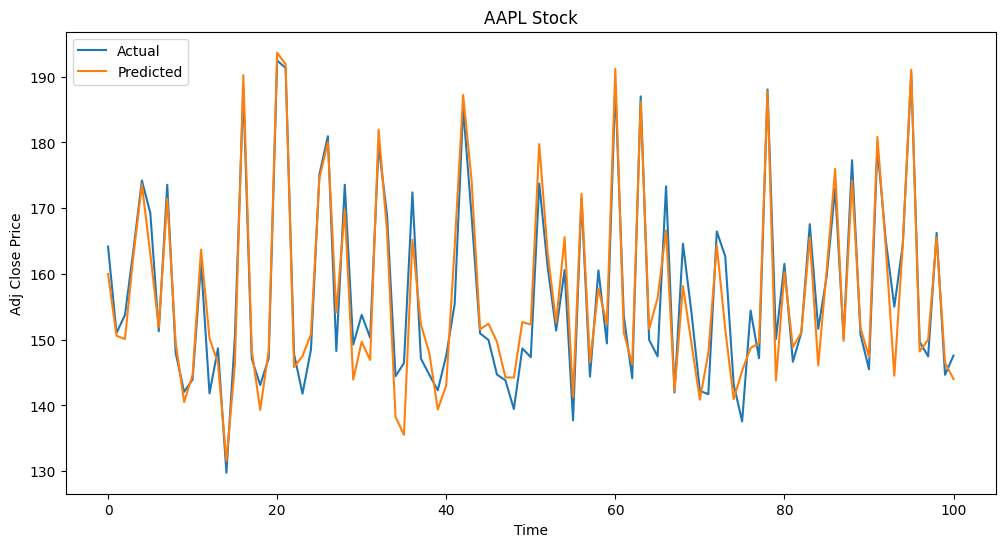

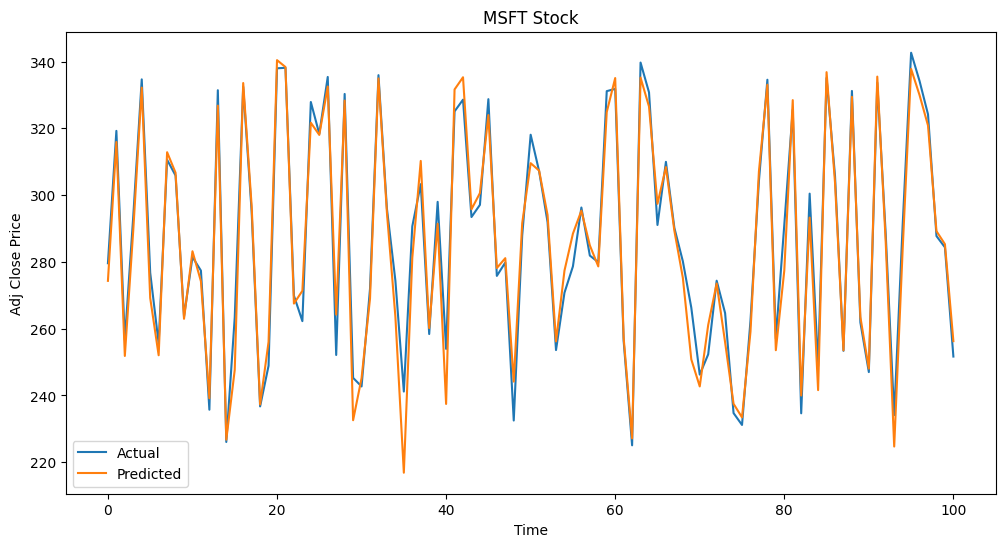

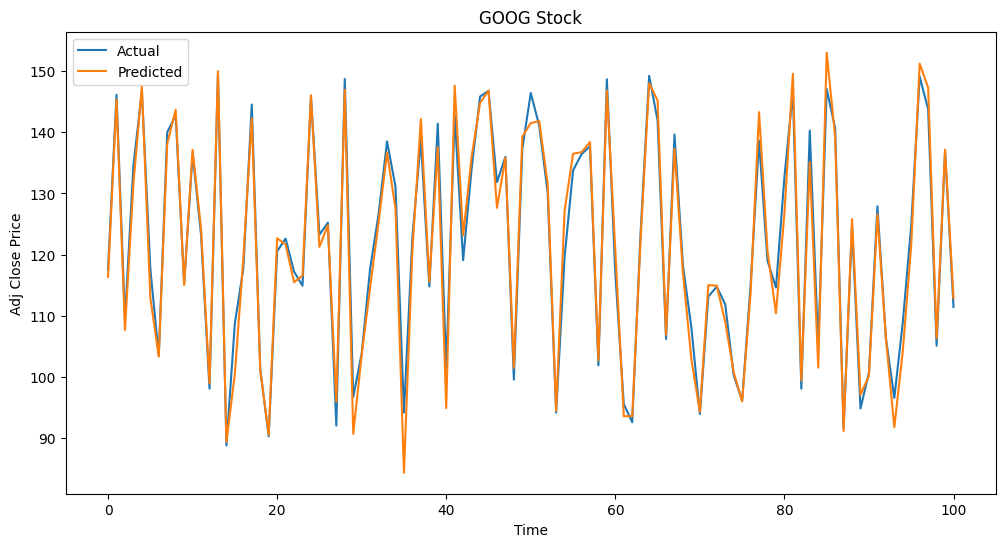

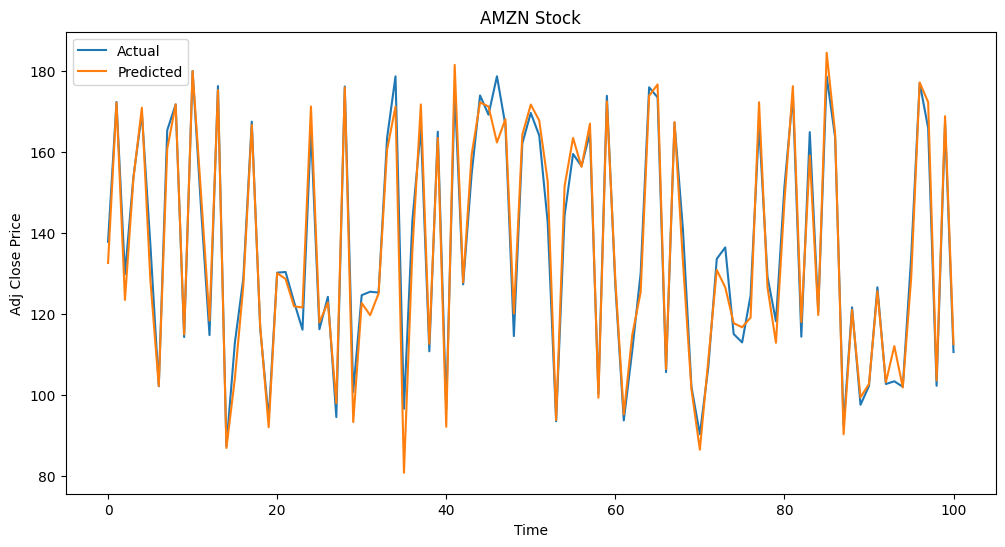

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# List of selected stocks to analyze
selected_stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN']

# Download stock data from Yahoo Finance
def download_data(tickers, period='2y', interval='1d'):
    try:
        data = yf.download(tickers=tickers, period=period, interval=interval, group_by='ticker', threads=True)
        return data
    except Exception as e:
        print(f"Error occurred during data download: {e}")
        return None

# Calculate technical indicators (EMA, RSI, PVT) for each stock
def calculate_technical_indicators(df):
    for ticker in selected_stocks:
        df['{}_EMA'.format(ticker)] = df[ticker]['Adj Close'].ewm(span=30, adjust=False).mean()
        df['{}_RSI'.format(ticker)] = compute_rsi(df[ticker]['Adj Close'])
        df['{}_PVT'.format(ticker)] = (df[ticker]['Adj Close'].pct_change() * df[ticker]['Volume']).cumsum()

    return df

# Compute Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Preprocess data and create the target variable (next day's Adj Close price)
def preprocess_data(df):
    df = df.fillna(method='ffill').dropna(how='all', axis=1)

    for ticker in selected_stocks:
        df[f'{ticker}_Next_Adj_Close'] = df[ticker]['Adj Close'].shift(-1)

    return df

# Perform data processing and custom train-test split
def custom_train_test_split(df):
    features = []
    target = []
    for ticker in selected_stocks:
        features.extend([f'{ticker}_EMA', f'{ticker}_RSI', f'{ticker}_PVT'])
        target.append(f'{ticker}_Next_Adj_Close')

    # Fill missing values in features using SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(df[features].values)

    # Fill missing values in target using forward fill
    df[target] = df[target].fillna(method='ffill')

    y = df[target].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

# Create and train the linear regression model
def create_linear_regression_model():
    model = LinearRegression()
    return model

# Download stock data with specified time period and interval
stocks_df = download_data(tickers=selected_stocks, period='2y', interval='1d')
if stocks_df is None:
    print("Exiting due to data download error.")
    exit()

# Calculate technical indicators for each stock
stocks_df = calculate_technical_indicators(stocks_df)

# Perform data preprocessing and create the target variable
stocks_df = preprocess_data(stocks_df)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = custom_train_test_split(stocks_df)

# Create and train the linear regression model
model = create_linear_regression_model()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on test data: {mse}")

# Plot predictions vs. actual for each stock
for i, ticker in enumerate(selected_stocks):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Adj Close Price')
    plt.title(f'{ticker} Stock')
    plt.legend()

plt.show()
